# Backprop is leaky abstract
 https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b

  autograd on the tensor level. micrograd was on scalar level.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
print(f"Xtr.shape, Ytr.shape: {Xtr.shape, Ytr.shape}")
print(f"Xdev.shape, Ydev.shape: {Xdev.shape, Ydev.shape}")
print(f"Xte.shape, Yte.shape: {Xte.shape, Yte.shape}")

Xtr.shape, Ytr.shape: (torch.Size([182625, 3]), torch.Size([182625]))
Xdev.shape, Ydev.shape: (torch.Size([22655, 3]), torch.Size([22655]))
Xte.shape, Yte.shape: (torch.Size([22866, 3]), torch.Size([22866]))


In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1 # using randn instead of zeros, because sometime zeros mask incorrect grads

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [9]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time
# replaced the F.cross_entropy with the manual cross entropy loss

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3338, grad_fn=<NegBackward0>)

In [10]:
logprobs.shape

torch.Size([32, 27])

In [ ]:
logprobs[range(n), Yb] # go thorugh the batch rows and puck the columns that match the target Yb
#loss is just mean of 32 numbers
# lets calcualte derivative of 3 numbers
# loss = -(a + b + c)/3
# dloss/da = -1/3
# dloss/db = -1/3
# dloss/dc = -1/3
# in our case n is 32, so dloss/d[i] = -1/32


tensor([-3.9584, -3.0086, -3.6479, -3.1868, -4.0837, -3.4324, -3.1798, -4.0636,
        -3.2954, -4.1258, -3.1650, -1.6764, -2.7656, -2.9176, -2.9671, -3.1245,
        -3.8080, -2.9617, -3.6151, -3.4887, -2.8878, -2.9745, -4.2065, -3.9156,
        -3.4396, -2.8716, -3.0829, -3.9465, -2.9243, -3.5122, -3.2660, -3.1817],
       grad_fn=<IndexBackward0>)

In [ ]:
# alos note that logprobs[range(n), Yb] is a vector of 32 numbers
# but logprbs is (32,27) but only 32 are non-zero, in other words reamining do not contributed to loss and have no gradient


In [49]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one
# dloss/dlogprobs = -1/n
dlogprob = torch.zeros_like(logprobs)
#now we need to set the non-zero values  which are at index range(n), Yb to -1/n
dlogprob[range(n), Yb] = -1.0/n
dlogprob.shape
cmp('dlogprob', dlogprob, logprobs) # cmp will get thte grad of logprob
# fidn teh derivative of logprobs with respect to probs
# we have a log node which takes in probs and outputs logprobs 
# #so dprob will the local derivative times loss w.r. output  whihc is dlogprob
dprobs = dlogprob * (1.0/probs) #d logx / dx = 1/x, chain it with dlogprobs
# intuitively this line is boostign the gradient of exampels that ahve low probability and probs are close to 1, information just gets passed
cmp('dprobs', dprobs, probs)
# now we need to find the derivative of probs with respect to counts
# probs = counts * counts_sum_inv # note there are two operations here 
# 1. broadcastign of counts_sum_inv which is of shape (32,1) and by torch broadcasting it becomes (32,27)
# 2. elementwise multiplication of counts (32,27) and counts_sum_inv (32,1) to become (32,27)
# let's first find the derivative of multiplication e.g a*b = c => dc/da = b, dc/db = a
# in out case b is counts_sum_inv and a is counts but b is replicated 27 times to become (32,27)
# dcounts_sum_inv = counts * dprobs is counts multiplied by derivative of output by chain rule 
dcounts_sum_inv = counts * dprobs 
# now we need to backprop through replication 
# in the computation graph if one node feeds into multiple nodes then the gradient is the sum of gradients of each feed
dcounts_sum_inv = dcounts_sum_inv.sum(1, keepdim=True) # sum over the 27 dims and keepdim to maintain the shape
cmp('dcounts_sum_inv', dcounts_sum_inv, counts_sum_inv)
# now we backprop through counts
dcounts = dprobs * counts_sum_inv # first branch of the computation graph
# counts has been used in another branch of the computation graph
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv # derivative of 1/x is -1/x^2
cmp('dcounts_sum', dcounts_sum, counts_sum)
# now we backprop thorugh counts_sum
# counts is of shape (32,27) and counts_sum is of shape (32,1)
# we are summing up rows to get counts_sum
#    a11 a12 a13 ----> b1(a11+a12+a13)
#    a21 a22 a23 ----> b2(a21+a22+a23)
#    a31 a32 a33 ----> b3(a31+a32+a33)
# so we need to sum up the gradients of each row to get the gradient of counts_sum
# derivative of b1 w.r,t a11, a12, a13 is 1, 1, 1
# derivative of b1 w.r.t. a11, a12, a13 is 0, 0, 0
# + operation is jsut router for the gradients, whatever gradient comes it gets routed to all the elements of the addtion
# so we jsut need to replicate the gradient of b1, b2, b3 to all the elements of the addition
dcounts += torch.ones_like(counts) * dcounts_sum # second branch of the computation graph we we need to acculate the gradient to first branch
cmp('dcounts', dcounts, counts)
dnorm_logits = dcounts * counts
cmp('dnorm_logits', dnorm_logits, norm_logits)
# now we need to find the derivative of norm_logits with respect to logits
# norm logits is of shape (32,27) and logits is of shape (32,27) and logit_maxes is of shape (32,1)
#   c11 c12 c13 = a11 a12 a13 - b1
#   c21 c22 c23 = a21 a22 a23 - b2
#   c31 c32 c33 = a31 a32 a33 - b3
# so bs will be broadcasted to (32,27) 
dlogits = dnorm_logits.clone() # first branch there is a second branch of this
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
cmp('dlogit_maxes', dlogit_maxes, logit_maxes)
# now let's do the derivative of logit_maxes = logits.max(1, keepdim=True).values
# this operation is plucking max values from each row of logits this is similar to dlogprobs
# so dlogit_maxes/dlogits = 1.0 if it is the max and 0.0 otherwise
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp('dlogits', dlogits, logits)
# now we need to find the derivative of logits with respect to h, w2, n2
# e.g. d = a@b + c #here c will be rowwise broadcasted to (32,27)
#  [d11 d12
#   d21 d22] = [a11 a12
#               a21 a22] @ [b11 b12
#                           b21 b22] + [c11 c12
#                                     c21 c22]

# => d11 = a11*b11 + a12*b21 + c11
# => d12 = a11*b12 + a12*b22 + c12
# => d21 = a21*b11 + a22*b21 + c21
# => d22 = a21*b12 + a22*b22 + c22
# so dlogits/da = b.T # in scalaer multiplication c = a*b dc/da = b and in matrix ist c = a@b dc/da = b.T
# so dlogits/db = a.T
# so dlogits/dc = 1
# https://youtu.be/q8SA3rM6ckI?t=2784

# logits = h @ W2 + b2
dh = dlogits @ W2.T
dw2 = h.T @ dlogits
db2 = dlogits.sum(0)
cmp('dh', dh, h)
cmp('dw2', dw2, W2)
cmp('db2', db2, b2)
# now we need derivative of hpreact with respect to hprebn, bngain, bnbias, hpreact
# a = tanh(b)
# da/db = (1-a^2) # note a is output of tanh
# so dlogits/dh = da/db * db/dh = (1-h^2) * W2
# so dh/db = 1
# so dh/db = 1
# so dh/db = 1
dhpreact = dh * (1-h**2)
cmp('dhpreact', dhpreact, hpreact)
# now we need to find the derivative of preact with respect to bnraw, bngain, bnbias
# hpreact is of shape (32,64) and bnraw is of shape (32,64) bngain is of shape (1,64) and bnbias is of shape (1,64)
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
cmp('dbngain', dbngain, bngain)

dbnraw = bngain * dhpreact
cmp('dbnraw', dbnraw, bnraw)

dbnbias = dhpreact.sum(0, keepdim=True)
cmp('dbnbias', dbnbias, bnbias)

dbndiff = bnvar_inv * dbnraw # there is second branch of this 
cmp('dbndiff', dbndiff, bndiff)

dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)
# now propagate through bnvar_inv = (bnvar + 1e-5)**-0.5
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
cmp('dbnvar', dbnvar, bnvar)
# now we backprop thhru bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)

# bnvar is of shape (1,64) and bndiff2 is of shape (32,64)
# a11 a12
# a21 a22
# --->
# b1, b2, where 
# b1 = 1/(n-1) * (a11+a21)
# b2 = 1/(n-1) * (a12+a22)
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
cmp('dbndiff2', dbndiff2, bndiff2)
dbndiff += 2*bndiff * dbndiff2
cmp('dbndiff', dbndiff, bndiff)

dhprebn = dbndiff.clone() # there is second branch of this 
cmp('dhprebn', dhprebn, hprebn)

dbnmeani = -dbndiff.sum(0, keepdim=True)
cmp('dbnmeani', dbnmeani, bnmeani)
dhprebn +=  torch.ones_like(hprebn) * (1.0/n* dbnmeani)
cmp('dhprebn', dhprebn, hprebn)
# now backprop forward pass
# dhprebn is of shape (32,64), embcat is of shape (32,30) W1 is of shape (30,64) and b1 is of shape (64,)
dembcat = dhprebn @ W1.T
cmp('dembcat', dembcat, embcat)
dW1 = embcat.T @ dhprebn
cmp('dW1', dW1, W1)
db1 = dhprebn.sum(0)
cmp('db1', db1, b1)
# now we need to find the derivative of embcat with respect to emb, C, Xb

demb = dembcat.view(emb.shape)
cmp('demb', demb, emb)
# now lets backprop thru emb = C[Xb]
# emb is of shape (32,3,10) and Xb is of shape (32,3) and C is of shape (27,10)
# Xb has the integers that represents the rows in C that  are plucked out and re-arranged to get emb
# demb is gradients fo those plucked rows
# dC = torch.zeros_like(C)
# for i in range(Xb.shape[0]):
#   for j in range(Xb.shape[1]):
#       ix = Xb[i,j]
#       dC[ix] += demb[i,j]
# above is https://youtu.be/q8SA3rM6ckI?t=4943
# vectorized version is below
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]
cmp('dC', dC, C)
# now we need to find the derivative of embcat with respect to emb, C, Xb



dlogprob        | exact: True  | approximate: True  | maxdiff: 0.0
dprobs          | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum     | exact: True  | approximate: True  | maxdiff: 0.0
dcounts         | exact: True  | approximate: True  | maxdiff: 0.0
dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0
dlogit_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
dlogits         | exact: True  | approximate: True  | maxdiff: 0.0
dh              | exact: True  | approximate: True  | maxdiff: 0.0
dw2             | exact: True  | approximate: True  | maxdiff: 0.0
db2             | exact: True  | approximate: True  | maxdiff: 0.0
dhpreact        | exact: True  | approximate: True  | maxdiff: 0.0
dbngain         | exact: True  | approximate: True  | maxdiff: 0.0
dbnraw          | exact: True  | approximate: True  | maxdiff: 0.0
dbnbias         | exact: True  | approximate: True  | maxdiff:

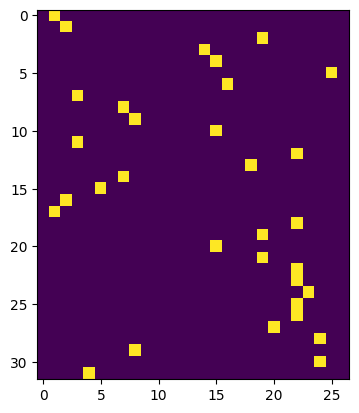

In [ ]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))
# shows the index of the max value in each row

In [50]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.333784341812134 diff: 0.0


In [51]:
# backward pass

dlogits = F.softmax(logits, 1) # along the rows  get logits 
dlogits[range(n), Yb] -= 1 # subtract 1 from the correct class
dlogits /= n # divide by n to get the mean

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


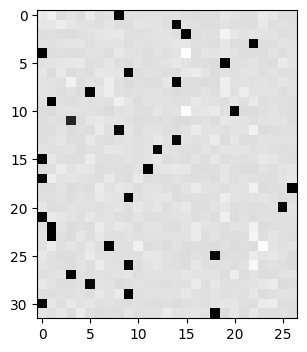

In [56]:
# what are dlogits really
# these are the probabilities in the forward pass
# black squares the position of the correct class
# gradient in each cell is like a force whihc pushes the probabilities of correct class up and down for incorrect classes. 

F.softmax(logits, 1)[0]
dlogits[0] * n
# both above are equal excpet the indices where the correct class is haas approx -1 for each calss 
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [57]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out


# https://youtu.be/q8SA3rM6ckI?t=5905
# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [58]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [59]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net

12297
      0/ 200000: 3.7786
  10000/ 200000: 2.1249
  20000/ 200000: 2.4054
  30000/ 200000: 2.4800
  40000/ 200000: 1.9950
  50000/ 200000: 2.3104
  60000/ 200000: 2.3609
  70000/ 200000: 1.9956
  80000/ 200000: 2.3495
  90000/ 200000: 2.1388
 100000/ 200000: 1.9322
 110000/ 200000: 2.2959
 120000/ 200000: 2.0657
 130000/ 200000: 2.4405
 140000/ 200000: 2.3302
 150000/ 200000: 2.1029
 160000/ 200000: 1.9076
 170000/ 200000: 1.8867
 180000/ 200000: 1.9956
 190000/ 200000: 1.8522


In [61]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

TypeError: all() received an invalid combination of arguments - got (bool), but expected one of:
 * (Tensor input, *, Tensor out = None)
 * (Tensor input, tuple of ints dim = None, bool keepdim = False, *, Tensor out = None)
 * (Tensor input, int dim, bool keepdim = False, *, Tensor out = None)
 * (Tensor input, name dim, bool keepdim = False, *, Tensor out = None)


In [62]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [63]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0691518783569336
val 2.109005928039551


In [64]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahzamille.
khi.
mri.
reet.
khalaysie.
mahnen.
delynn.
jareen.
nellara.
chaiivon.
leigh.
ham.
joce.
quint.
shon.
marianni.
waterri.
jaryn.
kai.
everludi.
